In [1]:
import os
from os.path import dirname
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unittest.mock import MagicMock, patch
from performance_data.data_table import PhaseData, DataTable
from performance_data.data_model import PhaseGenerator, RegressionModel, RandomForestModel


In [2]:
# check the dataset file
current_dir = dirname(dirname(os.getcwd()))
dataset_file = os.path.join(current_dir, "tests",
                            "test_data", "test_generated_dataset.csv")
complete_dataset_file = os.path.join(current_dir, "tests",
                                     "test_data", "complete_test_generated_dataset.csv")
complete_data = pd.read_csv(complete_dataset_file)
complete_data.head()
print(complete_data.columns)

Index(['nodes', 'read_volume', 'write_volume', 'read_io_pattern',
       'write_io_pattern', 'read_io_size', 'write_io_size', 'lfs_bw', 'nfs_bw',
       'sbb_bw'],
      dtype='object')


-0.6048396965987066


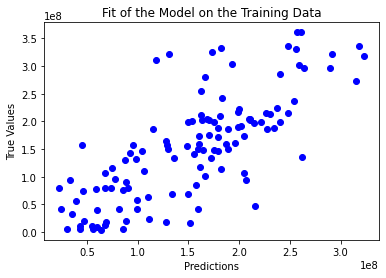

Index(['read_volume', 'write_volume', 'read_io_pattern', 'write_io_pattern',
       'read_io_size', 'write_io_size'],
      dtype='object')


In [3]:
# evaluate the model
model = RegressionModel(complete_dataset_file)
model.train_model()
print(model.evaluate_model())
def plot_fit(model):
        """
        Plots the fit of the model on the training data.
        """
        # Make predictions on the training data
        y_train_pred = model.predict(model.X_train)

        # Plot the fit of the model on the training data
        plt.scatter(y_train_pred, model.y_train, color='blue')
        plt.xlabel("Predictions")
        plt.ylabel("True Values")
        plt.title("Fit of the Model on the Training Data")
        plt.show()
        
plot_fit(model)
print(model.X_train.columns)

-0.6048396965987066


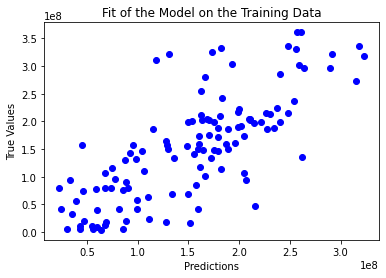

Index(['read_volume', 'write_volume', 'read_io_pattern', 'write_io_pattern',
       'read_io_size', 'write_io_size'],
      dtype='object')


In [4]:
# evaluate the model
model = RegressionModel(complete_dataset_file)
model.train_model()
print(model.evaluate_model())
def plot_fit(model):
        """
        Plots the fit of the model on the training data.
        """
        # Make predictions on the training data
        y_train_pred = model.predict(model.X_train)

        # Plot the fit of the model on the training data
        plt.scatter(y_train_pred, model.y_train, color='blue')
        plt.xlabel("Predictions")
        plt.ylabel("True Values")
        plt.title("Fit of the Model on the Training Data")
        plt.show()
        
plot_fit(model)
print(model.X_train.columns)

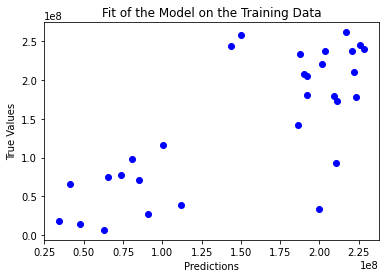

-0.5440669399532987


In [9]:
# evaluate the model
model = RandomForestModel(complete_dataset_file, num_trees=300)

def plot_fit(model):
        """
        Plots the fit of the model on the training data.
        """
        # Make predictions on the training data
        model.fit()
        y_pred = model.predict()
        # Plot the fit of the model on the training data
        plt.scatter(y_pred, model.y_test, color='blue')
        plt.xlabel("Predictions")
        plt.ylabel("True Values")
        plt.title("Fit of the Model on the Training Data")
        plt.show()
        
plot_fit(model)
print(model.evaluate())